In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! kaggle datasets download jonathanoheix/face-expression-recognition-dataset


 91% 110M/121M [00:01<00:00, 98.0MB/s] 
100% 121M/121M [00:01<00:00, 94.4MB/s]


In [6]:
! unzip face-expression-recognition-dataset

Streaming output truncated to the last 5000 lines.
  inflating: images/validation/fear/8797.jpg  
  inflating: images/validation/fear/8818.jpg  
  inflating: images/validation/fear/886.jpg  
  inflating: images/validation/fear/9037.jpg  
  inflating: images/validation/fear/9040.jpg  
  inflating: images/validation/fear/9101.jpg  
  inflating: images/validation/fear/911.jpg  
  inflating: images/validation/fear/9179.jpg  
  inflating: images/validation/fear/9205.jpg  
  inflating: images/validation/fear/9232.jpg  
  inflating: images/validation/fear/9251.jpg  
  inflating: images/validation/fear/9261.jpg  
  inflating: images/validation/fear/9281.jpg  
  inflating: images/validation/fear/9302.jpg  
  inflating: images/validation/fear/9333.jpg  
  inflating: images/validation/fear/9369.jpg  
  inflating: images/validation/fear/9370.jpg  
  inflating: images/validation/fear/9474.jpg  
  inflating: images/validation/fear/949.jpg  
  inflating: images/validation/fear/9602.jpg  
  inflating:

# ****IMPORTING IMPORTANT LIBRARIES****

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D

# **EXAMPLE**

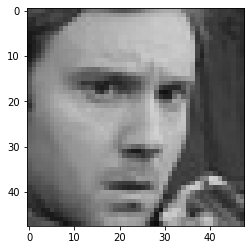

In [8]:
img_example=cv2.imread('/content/images/train/angry/0.jpg')
plt.imshow(img_example)


**SHAPE OF IMAGE**

In [9]:
img_shape=img_example.shape
img_shape

(48, 48, 3)

**CLASSES**

In [10]:
classes=[]
count=[]
for i in os.listdir("/content/images/train"):
    classes.append(i)
    count.append(len(os.listdir(os.path.join("/content/images/train",i))))
    print(i,len(os.listdir(os.path.join("/content/images/train",i))))


happy 7164
surprise 3205
angry 3993
disgust 436
fear 4103
sad 4938
neutral 4982


In [11]:
df1=pd.DataFrame()
df1['class']=classes
df1['count']=count
df1


,class,count
0,happy,7164
1,surprise,3205
2,angry,3993
3,disgust,436
4,fear,4103
5,sad,4938
6,neutral,4982


**COUNTPLOT**

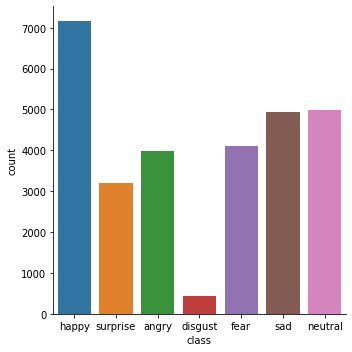

In [12]:
sns.catplot(data=df1,x="class",y="count",kind="bar")

# DATA AUGMENTATION

In [13]:
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,rotation_range=20,
                                                              data_format='channels_last',horizontal_flip=True,
                                                              width_shift_range=0.1,height_shift_range=0.1,
                                                              brightness_range=[0.2,1],shear_range=0.2,zoom_range=0.2)
test_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# LOADING DATA

In [14]:
train_datagen=train_datagen.flow_from_directory('/content/images/train',target_size=(48,48),batch_size=64,class_mode='categorical',shuffle=True)
test_datagen=test_datagen.flow_from_directory('/content/images/validation',target_size=(48,48),batch_size=64,class_mode='categorical',shuffle=False)


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [15]:
test_datagen.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

# LOADING SAMPLE IMAGES OF EACH CLASS

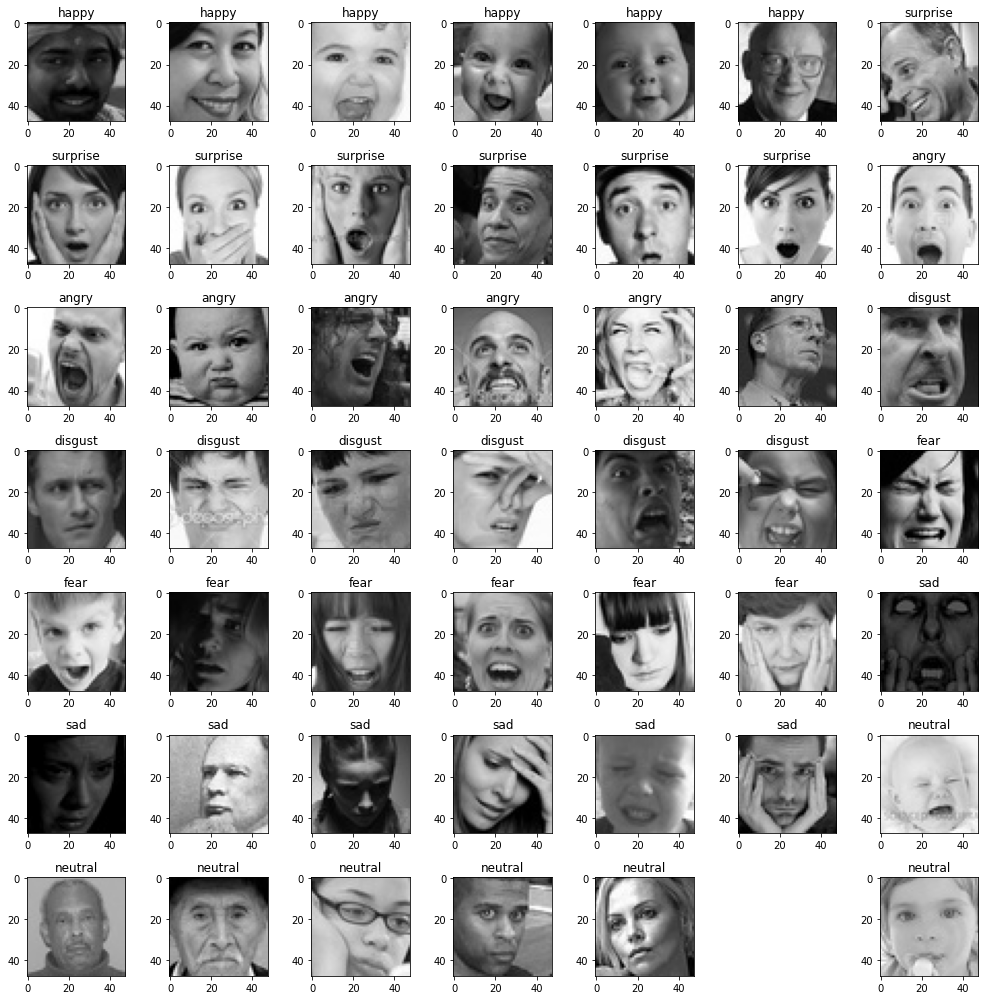

In [16]:
fig=plt.figure(1, (14, 14))
cnt=0
for param in classes:
    cnt_copy=0
    plt.title(param)
    path=os.path.join('/content/images/train',param)
    for img in os.listdir(path):
        if cnt_copy<7:
            cnt=cnt+1
            ax=plt.subplot(7,7,cnt)
            img=cv2.imread(os.path.join(path,img))
            ax.imshow(img)
            ax.set_title(param)
            plt.tight_layout()
            cnt_copy+=1
        else :
            break
            



```

```

**As you can see 1st image of neutral and 1st image of sad label aren't good training dataset example because our model might try to learn features which aren't important for it to learn for generalizing over test_dataset. It will certainly affect our accuracy as we will be seeing later on. Also some of the images have watermarks which leads to poor results while we train the model.
**

In [17]:
batch_train=next(train_datagen)
type(train_datagen)

keras.preprocessing.image.DirectoryIterator

In [18]:
print(batch_train[0][0].shape)

(48, 48, 3)


In [19]:
type(batch_train[0])

numpy.ndarray

In [20]:
type(batch_train)

tuple

**SAMPLE IMAGES IN A SHUFFLED BATCH**

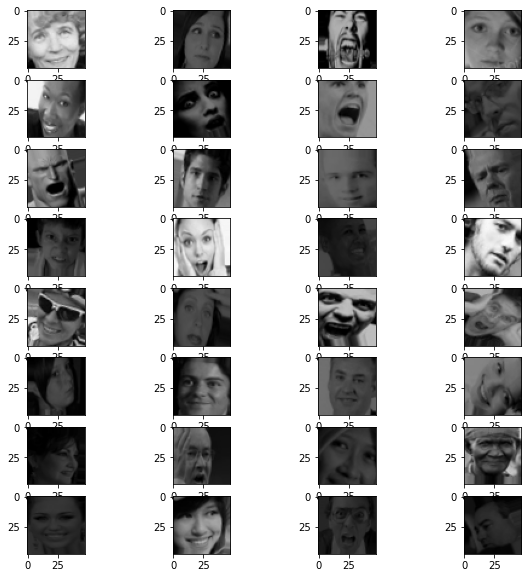

In [21]:
plt.figure(figsize=(10,10))
for i in range(32):
    plt.subplot(8,4,i+1)
    plt.imshow(batch_train[0][i])
plt.show()    
    
    

**The third image of this batch has a watermark in it. Also 9th image of this batch is a character(Not even a real person) Evidently the dataset wasen't good for training the model.**

# CHECKPOINTS

In [22]:
# save_callback=tf.keras.callbacks.ModelCheckpoint(filepath='./checkpoint',save_weights_only=False,monitor='val_loss',
#                                              save_best_only=True)
# checkpoint_path="./"
# checkpoint_dir = os.path.dirname(checkpoint_path)

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


early_stop= EarlyStopping(
                                monitor = "val_accuracy",
                                min_delta=0.001,
                                patience=5,
                                verbose=1,
                                mode="max")

reduce_lr = ReduceLROnPlateau(
                                monitor="val_accuracy",
                                factor=0.1,
                                patience=2,
                                verbose=1,
                                min_delta=0.0001)

**MOBILE NET**

In [23]:
base_model=tf.keras.applications.MobileNet(include_top=False,weights='imagenet',input_shape=(48,48,3))

model=Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(7,activation='softmax'))    

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

for layers in base_model.layers:
    layers.trainable=False

model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1, 1, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                         

In [24]:
# train = train_datagen.cache().prefetch(tf.data.AUTOTUNE)
# val  = test_datagen.cache().prefetch(tf.data.AUTOTUNE)

**TRAINING MODEL**

In [25]:
history=model.fit_generator(train_datagen,validation_data=test_datagen,epochs=20,
                            steps_per_epoch=train_datagen.n//train_datagen.batch_size,
                            validation_steps=test_datagen.n//test_datagen.batch_size,verbose=1,
                            callbacks=[early_stop,reduce_lr])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/20
450/450 [==============================] - 102s 191ms/step - loss: 1.7312 - accuracy: 0.3643 - val_loss: 1.4048 - val_accuracy: 0.4692 - lr: 0.0010
Epoch 2/20
450/450 [==============================] - 89s 197ms/step - loss: 1.3900 - accuracy: 0.4736 - val_loss: 1.2555 - val_accuracy: 0.5307 - lr: 0.0010
Epoch 3/20
450/450 [==============================] - 78s 172ms/step - loss: 1.2793 - accuracy: 0.5176 - val_loss: 1.1653 - val_accuracy: 0.5661 - lr: 0.0010
Epoch 4/20
450/450 [==============================] - 77s 171ms/step - loss: 1.2254 - accuracy: 0.5392 - val_loss: 1.1506 - val_accuracy: 0.5720 - lr: 0.0010
Epoch 5/20
450/450 [==============================] - 81s 179ms/step - loss: 1.1895 - accuracy: 0.5512 - val_loss: 1.1851 - val_accuracy: 0.5507 - lr: 0.0010
Epoch 6/20
450/450 [==============================] - ETA: 0s - loss: 1.1695 - accuracy: 0.5599
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
450/450 [=======================

**SAVING MODEL**

# PLOTTING ACCURACY AND LOSS CURVES

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

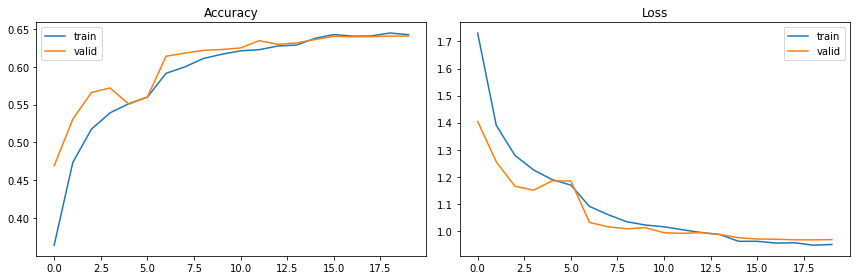

In [26]:
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.show()

In [27]:
predictions=model.predict(test_datagen, batch_size=64)
predicted_classes = np.argmax(predictions,axis=1)
true_labels=test_datagen.classes

# CONFUSION MATRIX

              precision    recall  f1-score   support

           0       0.57      0.54      0.55       960
           1       0.71      0.50      0.58       111
           2       0.53      0.37      0.43      1018
           3       0.86      0.85      0.86      1825
           4       0.53      0.71      0.61      1216
           5       0.50      0.52      0.51      1139
           6       0.77      0.72      0.74       797

    accuracy                           0.64      7066
   macro avg       0.64      0.60      0.61      7066
weighted avg       0.64      0.64      0.64      7066



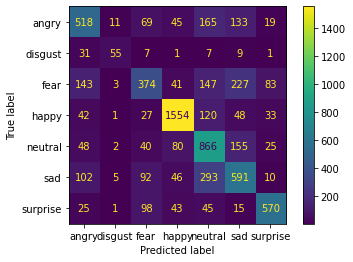

In [28]:
# import scikitplot
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred=model.predict(test_datagen)
y_pred=np.argmax(y_pred,axis=1)

cm=confusion_matrix(test_datagen.classes,y_pred)

target_names=['angry','disgust','fear','happy','neutral','sad','surprise']

print(classification_report(test_datagen.classes,y_pred))

matrix=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
matrix.plot()
plt.show()


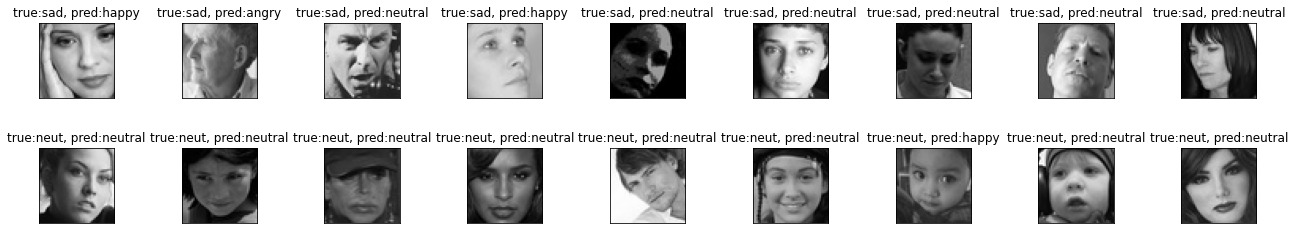

In [29]:
mapper = {0:'angry',
 1:'disgust',
 2:'fear',
 3:'happy',
 4:'neutral',
 5:'sad',
 6:'surprise'}

sad_path="/content/images/validation/sad"
neutral_path="/content/images/validation/neutral"

neutral_filenames = np.random.choice([x for x in os.listdir(neutral_path) 
                                     if os.path.isfile(os.path.join(neutral_path, x))],size=9)

sad_filenames = np.random.choice([x for x in os.listdir(sad_path) 
                                     if os.path.isfile(os.path.join(sad_path, x))],size=9)


fig = plt.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(sad_filenames, neutral_filenames)):
        ax = plt.subplot(2, 9, i+1)
        sadidx=os.path.join(sad_path,sadidx)
        sample_img = cv2.imread(sadidx)
        plt.imshow(sample_img)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:sad, pred:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,3)))]}")

        ax = plt.subplot(2, 9, i+10)
        neuidx=os.path.join(neutral_path,neuidx)
        sample_img1 = cv2.imread(neuidx)
        ax.imshow(sample_img1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:neut, pred:{mapper[np.argmax(model.predict(sample_img1.reshape(1,48,48,3)))]}")

        plt.tight_layout()


# **EFFICIENT NET**

In [30]:
# from tensorflow.keras.applications.efficientnet import EfficientNetB2
# base_model_efficientnet=EfficientNetB2(include_top=False,weights='imagenet',input_shape=(48,48,3))
# # model1=Sequential()
# # model1.add(base_model_efficientnet)
# # model1.add(Flatten())
# # model1.add(Dense(256,activation='relu'))
# # model1.add(Dense(128,activation='relu'))
# # model1.add(Dense(7,activation='softmax'))
# x=Flatten()(base_model_efficientnet.output)
# # x=Dense(256,activation='relu')(x)
# # x = keras.layers.Dropout(0.1)(x)
# # x=Dense(64,activation='relu')(x)
# # x = keras.layers.Dropout(0.1)(x)
# pred=Dense(7,activation='softmax')(x)
# model1=Model(base_model_efficientnet.input,outputs=pred)
# # when the layers arwe in a foood mooofa ehrlh ldf fhlsaa

# for layers in base_model_efficientnet.layers:
#     layers.trainable=False    
    
# model1.summary()

In [31]:
# model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
# model1.fit_generator(train_datagen,validation_data=test_datagen,steps_per_epoch=len(train_datagen),
#                      validation_steps=len(test_datagen),
#                      epochs=1,callbacks=[early_stop,reduce_lr])

In [32]:
import pickle

In [33]:
pickle.dump(model,open('emotion_detector.p','wb'))

INFO:tensorflow:Assets written to: ram://ca1c9d0c-1c04-4ae0-b537-53a600dc553e/assets


INFO:tensorflow:Assets written to: ram://ca1c9d0c-1c04-4ae0-b537-53a600dc553e/assets


In [34]:
my_model=pickle.load(open('emotion_detector.p','rb'))

In [ ]:
# from skimage import color
# from PIL import Image
# url=input("Enter the url of the image")

# test_img=cv2.imread(url)
# # test_img=tf.image.rgb_to_grayscale(test_img)
# test_img=cv2.cvtColor(test_img,cv2.COLOR_RGB2GRAY)
# test_img=cv2.resize(test_img,(48,48))
# test_img = np.stack((test_img,)*3, axis=-1)

# # test_img=Image.open(url).convert('L')

# # test_prediction=my_model.predict(test_img)
# # test_prediction=np.argmax(test_prediction,axis=1)
# test_prediction=mapper[np.argmax(my_model.predict(test_img.reshape(1,48,48,3)))]
# print(f'PREDICTED OUTPUT : {test_prediction}')



In [35]:
! pip install streamlit
! pip install pyngrok
from pyngrok import ngrok

     |████████████████████████████████| 9.2 MB 5.3 MB/s 
     |████████████████████████████████| 111 kB 30.4 MB/s 
     |████████████████████████████████| 76 kB 3.7 MB/s 
     |████████████████████████████████| 180 kB 35.6 MB/s 
     |████████████████████████████████| 4.3 MB 25.4 MB/s 
     |████████████████████████████████| 164 kB 35.3 MB/s 
     |████████████████████████████████| 63 kB 1.2 MB/s 
     |████████████████████████████████| 126 kB 32.0 MB/s 
     |████████████████████████████████| 791 kB 30.7 MB/s 
     |████████████████████████████████| 374 kB 35.9 MB/s 
  Created wheel for blinker: filename=blinker-1.4-py3-none-any.whl size=13478 sha256=6939ff70ed751187a14978d7246067d8d3c37336b1386678e5588a2acd04aef5
  Stored in directory: /root/.cache/pip/wheels/22/f5/18/df711b66eb25b21325c132757d4314db9ac5e8dabeaf196eab
Successfully built blinker
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      S

     |████████████████████████████████| 745 kB 5.4 MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.1.0-py3-none-any.whl size=19006 sha256=e4e4f05f5c03016c6dba8f55c9af8c5ca5be698c1a6492684425fd42b00dc4fd
  Stored in directory: /root/.cache/pip/wheels/bf/e6/af/ccf6598ecefecd44104069371795cb9b3afbcd16987f6ccfb3
Successfully built pyngrok


In [36]:
!ngrok authtoken 22HtgSW3QzdSdYneqWuAjGaccOP_5J1Ssid5tr3r1S4zMhPoK


Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [37]:
!nohup streamlit run app.py &

nohup: appending output to 'nohup.out'


In [38]:
ngrok.kill()

In [39]:
# from pyngrok import ngrok
# url=ngrok.connect(port=8501)
# url

In [40]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

--2021-12-24 19:10:32--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.202.168.65, 54.237.133.81, 18.205.222.128, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.202.168.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  6.29MB/s    in 2.1s    

2021-12-24 19:10:35 (6.29 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]



In [41]:
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [43]:
%%writefile app_1.py
import streamlit as st
import numpy as np
import os
import cv2
import pickle
from PIL import Image
from skimage import color

mapper = {0:'angry',
 1:'disgust',
 2:'fear',
 3:'happy',
 4:'neutral',
 5:'sad',
 6:'surprise'}

st.title("EMOTION DETECTOR")
st.text("Upload your image to predict your emotion")
my_model=pickle.load(open('emotion_detector.p','rb'))
upload_file=st.file_uploader("Browse Image",type=["jpg",'png','jpeg'])
if upload_file is not None:
  img=Image.open(upload_file)
  st.image(img,caption="Uploaded Image")
  if st.button("PREDICT"):
    st.write("Result....")
    img=cv2.cvtColor(np.array(img),cv2.COLOR_RGB2GRAY)
    img=cv2.resize(img,(48,48))
    img = np.stack((img,)*3, axis=-1)

    # test_img=Image.open(url).convert('L')

    # test_prediction=my_model.predict(test_img)
    # test_prediction=np.argmax(test_prediction,axis=1)
    test_prediction=mapper[np.argmax(my_model.predict(img.reshape(1,48,48,3)))]
    st.write(f'PREDICTED OUTPUT : {test_prediction}')



Writing app_1.py


In [ ]:
get_ipython().system_raw('./ngrok http 8501 &')


In [ ]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'


In [ ]:
  !streamlit run /content/app.py